# IMPORT LIBRARIES

In [27]:
import pandas as pd
import numpy as np
import sys
import os
import random
from pathlib import Path

# Image processing
import imageio
import cv2
import skimage.transform


# Charts
import matplotlib.pyplot as plt
import seaborn as sns

# ML, statistics
import scipy
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, ConfusionMatrixDisplay

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, Activation, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, AveragePooling2D, MaxPool2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import backend as K

# SETTINGS

## Global

In [8]:
# Settings
plt.style.use('fivethirtyeight')
#plt.style.use('seaborn')

# toy=True - development mode, small samples, limited training, fast run
# toy=False - full data, slow learning and run
toy=False

#set size of validation set and test set in percentage
validation_size = 10
test_size = 10

# Generators Paramenters
batch_size = 32
img_size = (224,224)

## Dataset Parameters

In [9]:
# Dataset Root Path
dataset_path = "../input/covid19-radiography-database/COVID-19_Radiography_Dataset"

# Folder Paths
covid_path = dataset_path + "/COVID/images"
lungOpacity_path = dataset_path + "/Lung_Opacity/images"
normal_path = dataset_path + "/Normal/images"
viralPneumonia_path = dataset_path + "/Viral Pneumonia/images"

# LABELS LOCAL Array
#labels = ['COVID', 'Lung Opacity', 'Normal', 'Viral Pneumonia']
labels = ['COVID', 'Normal', 'Viral Pneumonia']

# DATA PREPARATION

In [10]:
# Generate Filename list
def filename_list():

    if toy :
        random.seed(100)
        filenames = random.sample(os.listdir(covid_path), 200) + random.sample(os.listdir(lungOpacity_path), 200) + random.sample(os.listdir(normal_path), 200) + random.sample(os.listdir(viralPneumonia_path), 200)
    else :
       #filenames = os.listdir(covid_path) + os.listdir(lungOpacity_path) + os.listdir(normal_path) + os.listdir(viralPneumonia_path)
        filenames = os.listdir(covid_path) + os.listdir(normal_path) + os.listdir(viralPneumonia_path)

    return filenames

In [11]:
def dataframe_generation(files):
    
    categories = []
    for filename in files:
        category = filename.split('-')[0]
        if category == labels[0]:
            categories.append(str(0))
        elif category == labels[1]:
            categories.append(str(1))
        elif category == labels[2]:
            categories.append(str(2))
        #elif category == labels[3]:
         #   categories.append(str(3))

    for i in range(len(files)):
        if labels[0] in files[i]:
            files[i] = os.path.join(covid_path, files[i])
        #elif labels[1] in files[i]:
            #files[i] = os.path.join(lungOpacity_path, files[i])
        elif labels[1] in files[i]:
            files[i] = os.path.join(normal_path, files[i])
        elif labels[2] in files[i]:
            files[i] = os.path.join(viralPneumonia_path, files[i])
    
    df = pd.DataFrame({
        'filename': files,
        'category': categories
    })

    return df

## Generate Dataset

In [12]:
filenames = filename_list()
dataset_df = dataframe_generation(filenames)

dataset_df.head()

,filename,category
0,../input/covid19-radiography-database/COVID-19...,0
1,../input/covid19-radiography-database/COVID-19...,0
2,../input/covid19-radiography-database/COVID-19...,0
3,../input/covid19-radiography-database/COVID-19...,0
4,../input/covid19-radiography-database/COVID-19...,0


In [13]:
def read_img(id):
    """
    Read image by it's id
    """
    file=id
    im=cv2.imread(file)
    return im

def draw_sample_images(dataframe, ncols, labels):

        ncols=ncols
        n_rows = len(labels)

        f, ax = plt.subplots(nrows=n_rows,ncols=ncols, 
                             figsize=(4*ncols,5*2))
        i=-1
        captions=labels
        
        for label in range(n_rows):
            i=i+1
            samples = dataframe[dataframe["category"].astype(int) == label].filename.sample(ncols).values
            for j in range(0,ncols):
                file_id=samples[j]
                im=read_img(file_id)
                ax[i, j].imshow(im)
                ax[i, j].set_title(captions[i], fontsize=16)  
        plt.tight_layout()
        plt.show()

In [14]:
def plot_data_distribution(dataframe):
    dataframe.category.value_counts().plot(kind='bar')
    plt.title('Dataset Distribution')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.show()

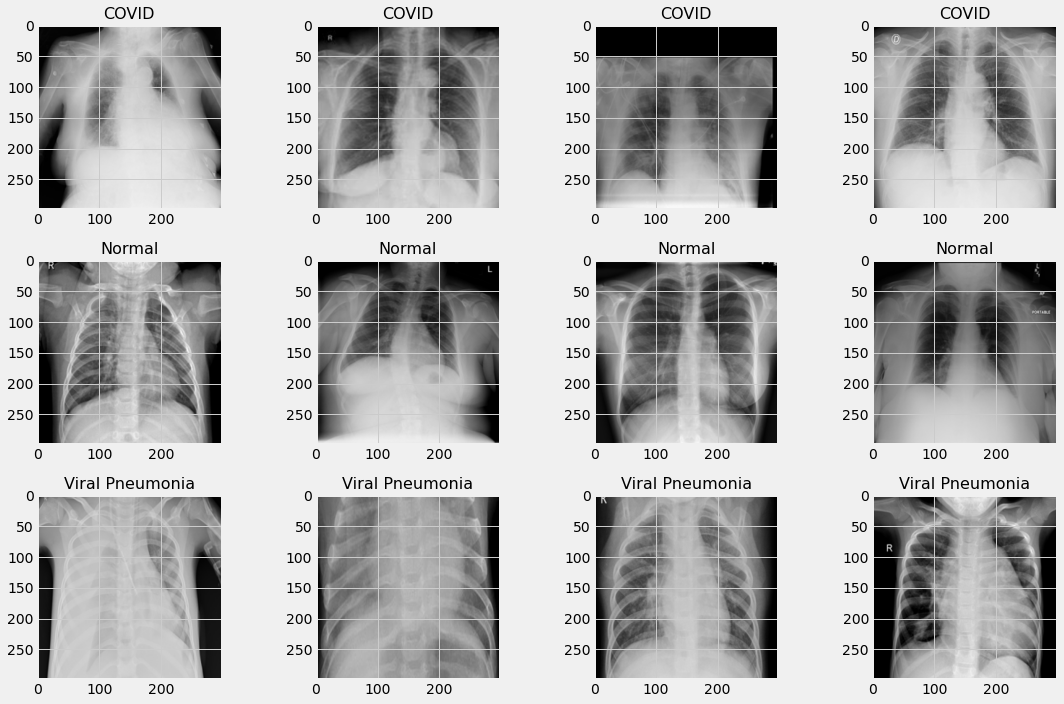

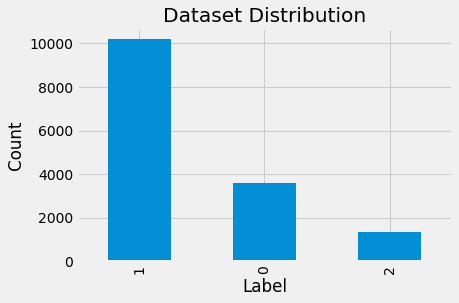

In [15]:
draw_sample_images(dataset_df, 4, labels)
plot_data_distribution(dataset_df)

## Dataset Balancing

In [16]:
def data_reduction(size):
    random.seed(100)
    reduced_dataset = random.sample(os.listdir(covid_path), size) + random.sample(os.listdir(normal_path), size) + random.sample(os.listdir(viralPneumonia_path), size)

    df_reduced = dataframe_generation(reduced_dataset)

    return df_reduced

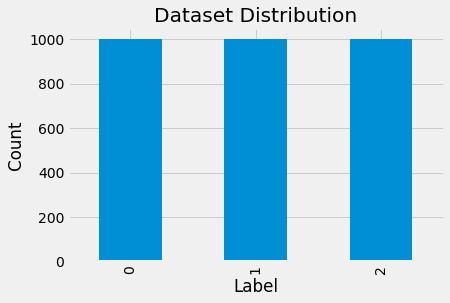

In [17]:
df_Reduced = data_reduction(1000)
plot_data_distribution(df_Reduced)

## Split in Train, Validation and Test

In [18]:
def sets_split(dataframe):
    x_1_split = (validation_size + test_size)/100
    x_2_split = round(test_size / (validation_size + test_size), 2)

    train_df, valTest_df = train_test_split(dataframe, test_size=x_1_split, random_state=24)
    val_df, test_df = train_test_split(valTest_df, test_size=x_2_split, random_state=24)

    return train_df, val_df, test_df

In [19]:
train, validation, test = sets_split(dataset_df)

## Generators

In [20]:
_datagen = ImageDataGenerator(
            rotation_range=15,
            rescale=1./255,
            shear_range=0.1,
            zoom_range=0.2,
            horizontal_flip=True,
            width_shift_range=0.1,
            height_shift_range=0.1   
            )

_test_datagen=ImageDataGenerator(rescale=1./255)

In [21]:
train_generator = _datagen.flow_from_dataframe(
            dataframe=train,
            x_col="filename",
            y_col="category",
            batch_size=batch_size,
            seed=42,
            shuffle=True,
            class_mode="categorical",
            color_mode="rgb",
            target_size=img_size)
print('Train generator created')

Found 12122 validated image filenames belonging to 3 classes.
Train generator created


In [22]:
val_generator = _test_datagen.flow_from_dataframe(
            dataframe=validation,
            x_col="filename",
            y_col="category",
            batch_size=batch_size,
            seed=42,
            shuffle=False,
            class_mode="categorical",
            color_mode="rgb",
            target_size=img_size)    
print('Validation generator created')

Found 1515 validated image filenames belonging to 3 classes.
Validation generator created


In [23]:
test_generator = _test_datagen.flow_from_dataframe(
            dataframe=test,
            x_col="filename",
            y_col=None,
            class_mode=None,
            batch_size=batch_size,
            seed=42,
            shuffle=False,
            color_mode="rgb",
            target_size=img_size)     
print('Test generator created')

Found 1516 validated image filenames.
Test generator created


# MODEL GENERATION

## Metrics Aux Functions

In [24]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Model Creation

In [28]:
def create_model(size):
        model = Sequential()

        model.add(BatchNormalization(input_shape=(224,224,3)))
        model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
        model.add(MaxPool2D(pool_size=(2,2)))
        model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
        model.add(MaxPool2D(pool_size=(2,2)))
        model.add(Dropout(0.35))

        model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
        model.add(MaxPool2D(pool_size=(2,2)))
        model.add(Dropout(0.35))

        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.35))
        model.add(Dense(3, activation='softmax'))
            
        model.compile(optimizer= Adam(0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', f1_m, precision_m, recall_m])
        
        return model

In [30]:
model = create_model(224)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_2 (Batch (None, 224, 224, 3)       12        
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 54, 54, 32)       

## Define Trainer

In [31]:
from keras.callbacks import Callback
import matplotlib.pyplot as plt    
import matplotlib.patches as mpatches  
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np


class AccLossPlotter(Callback):
    """Plot training Accuracy and Loss values on a Matplotlib graph. 
    The graph is updated by the 'on_epoch_end' event of the Keras Callback class
    # Arguments
        graphs: list with some or all of ('acc', 'loss')
        save_graph: Save graph as an image on Keras Callback 'on_train_end' event 
    """

    def __init__(self, graphs=['acc', 'loss'], save_graph=False):
        self.graphs = graphs
        self.num_subplots = len(graphs)
        self.save_graph = save_graph


    def on_train_begin(self, logs={}):
        self.acc = []
        self.val_acc = []
        self.loss = []
        self.val_loss = []
        self.epoch_count = 0
        plt.ion()
        plt.show()


    def on_epoch_end(self, epoch, logs={}):
        self.epoch_count += 1
        self.val_acc.append(logs.get('val_acc'))
        self.acc.append(logs.get('acc'))
        self.loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))
        epochs = [x for x in range(self.epoch_count)]

        count_subplots = 0
        
        if 'acc' in self.graphs:
            count_subplots += 1
            plt.subplot(self.num_subplots, 1, count_subplots)
            plt.title('Accuracy')
            #plt.axis([0,100,0,1])
            plt.plot(epochs, self.val_acc, color='r')
            plt.plot(epochs, self.acc, color='b')
            plt.ylabel('accuracy')

            red_patch = mpatches.Patch(color='red', label='Test')
            blue_patch = mpatches.Patch(color='blue', label='Train')

            plt.legend(handles=[red_patch, blue_patch], loc=4)

        if 'loss' in self.graphs:
            count_subplots += 1
            plt.subplot(self.num_subplots, 1, count_subplots)
            plt.title('Loss')
            #plt.axis([0,100,0,5])
            plt.plot(epochs, self.val_loss, color='r')
            plt.plot(epochs, self.loss, color='b')
            plt.ylabel('loss')

            red_patch = mpatches.Patch(color='red', label='Test')
            blue_patch = mpatches.Patch(color='blue', label='Train')

            plt.legend(handles=[red_patch, blue_patch], loc=4)
        
        plt.draw()
        plt.pause(0.001)

    def on_train_end(self, logs={}):
        if self.save_graph:
            plt.savefig('training_acc_loss.png')

class ConfusionMatrixPlotter(Callback):
    """Plot the confusion matrix on a graph and update after each epoch
    # Arguments
        X_val: The input values 
        Y_val: The expected output values
        classes: The categories as a list of string names
        normalize: True - normalize to [0,1], False - keep as is
        cmap: Specify matplotlib colour map
        title: Graph Title
    """
    def __init__(self, X_val, Y_val, classes, normalize=False, cmap=plt.cm.Blues, title='Confusion Matrix'):
        self.X_val = X_val
        self.Y_val = Y_val
        self.title = title
        self.classes = classes
        self.normalize = normalize
        self.cmap = cmap
        plt.ion()
        #plt.show()
        plt.figure()

        plt.title(self.title)
        
        

    def on_train_begin(self, logs={}):
        pass

    
    def on_epoch_end(self, epoch, logs={}):    
        plt.clf()
        pred = self.model.predict(self.X_val)
        max_pred = np.argmax(pred, axis=1)
        max_y = self.Y_val
        max_y=max_y[:len(max_pred)] 
        cnf_mat = confusion_matrix(max_y, max_pred)
   
        if self.normalize:
            cnf_mat = cnf_mat.astype('float') / cnf_mat.sum(axis=1)[:, np.newaxis]

        thresh = cnf_mat.max() / 2.
        for i, j in itertools.product(range(cnf_mat.shape[0]), range(cnf_mat.shape[1])):
            plt.text(j, i, cnf_mat[i, j],                                          
                         horizontalalignment="center",
                         color="white" if cnf_mat[i, j] > thresh else "black")

        plt.imshow(cnf_mat, interpolation='nearest', cmap=self.cmap)

        # Labels
        tick_marks = np.arange(len(self.classes))
        plt.xticks(tick_marks, self.classes, rotation=45)
        plt.yticks(tick_marks, self.classes)

        plt.colorbar()
                                                                                                         
        plt.tight_layout()                                                    
        plt.ylabel('True label')                                              
        plt.xlabel('Predicted label')                                         
        #plt.draw()
        plt.show()
        plt.pause(0.001)

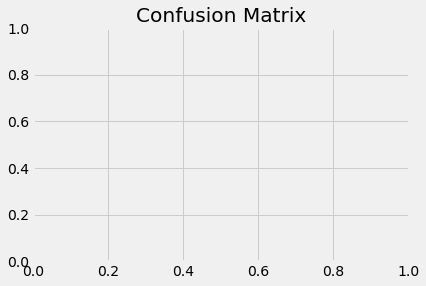

In [32]:
plotter = ConfusionMatrixPlotter(X_val=val_generator, classes=labels, Y_val=validation.category.values.astype(int))

In [33]:
def train(model, train_data, val_data, toy):
        """
        Train the model
        """
        if toy:
            epochs=3

        else:
            epochs=100
            
        # We'll stop training if no improvement after some epochs
        earlystopper = EarlyStopping(monitor='val_loss', mode='min', patience=5 , restore_best_weights=True)

        # Save the best model during the traning
        checkpointer = ModelCheckpoint('best_model1.h5'
                                        ,monitor='val_loss'
                                        ,mode='min'
                                        ,verbose=1
                                        ,save_best_only=True)
        # Train
        training = model.fit(train_data, 
                            validation_data = val_data, 
                            epochs = epochs, 
                            verbose = 1,
                            batch_size = batch_size,
                            callbacks=[earlystopper, checkpointer,plotter])
        
        print("Trained")
                            
        return training

2022-03-22 21:08:40.739326: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-03-22 21:08:43.226300: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


379/379 [==============================] - 224s 569ms/step - loss: 0.6367 - accuracy: 0.7083 - f1_m: 0.7016 - precision_m: 0.7256 - recall_m: 0.6802 - val_loss: 0.5592 - val_accuracy: 0.7578 - val_f1_m: 0.7483 - val_precision_m: 0.7982 - val_recall_m: 0.7058

Epoch 00001: val_loss improved from inf to 0.55916, saving model to best_model1.h5


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


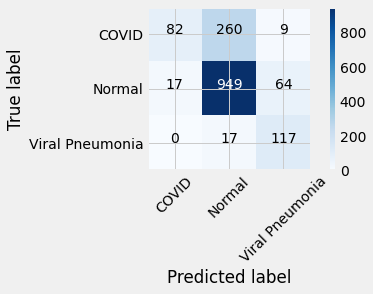

Epoch 2/100
379/379 [==============================] - 157s 415ms/step - loss: 0.5613 - accuracy: 0.7418 - f1_m: 0.7379 - precision_m: 0.7553 - recall_m: 0.7219 - val_loss: 0.5414 - val_accuracy: 0.8112 - val_f1_m: 0.7982 - val_precision_m: 0.8586 - val_recall_m: 0.7482

Epoch 00002: val_loss improved from 0.55916 to 0.54144, saving model to best_model1.h5


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


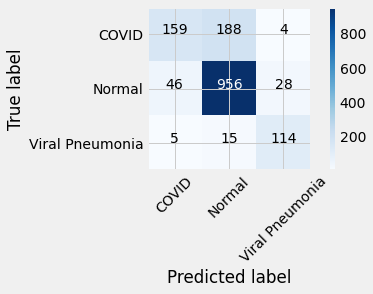

Epoch 3/100
379/379 [==============================] - 157s 415ms/step - loss: 0.5130 - accuracy: 0.7694 - f1_m: 0.7647 - precision_m: 0.7802 - recall_m: 0.7503 - val_loss: 0.4376 - val_accuracy: 0.8231 - val_f1_m: 0.8188 - val_precision_m: 0.8331 - val_recall_m: 0.8055

Epoch 00003: val_loss improved from 0.54144 to 0.43761, saving model to best_model1.h5


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


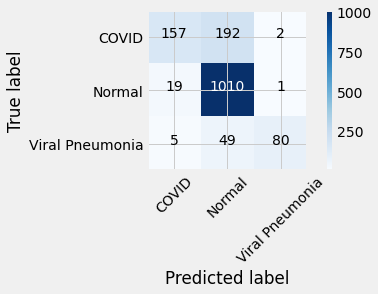

Epoch 4/100
379/379 [==============================] - 157s 415ms/step - loss: 0.4825 - accuracy: 0.7826 - f1_m: 0.7799 - precision_m: 0.7926 - recall_m: 0.7680 - val_loss: 0.3790 - val_accuracy: 0.8627 - val_f1_m: 0.8605 - val_precision_m: 0.8698 - val_recall_m: 0.8516

Epoch 00004: val_loss improved from 0.43761 to 0.37903, saving model to best_model1.h5


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


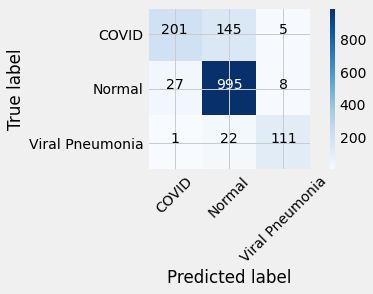

Epoch 5/100
379/379 [==============================] - 161s 425ms/step - loss: 0.4634 - accuracy: 0.7948 - f1_m: 0.7933 - precision_m: 0.8046 - recall_m: 0.7826 - val_loss: 0.3675 - val_accuracy: 0.8383 - val_f1_m: 0.8368 - val_precision_m: 0.8444 - val_recall_m: 0.8295

Epoch 00005: val_loss improved from 0.37903 to 0.36747, saving model to best_model1.h5


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


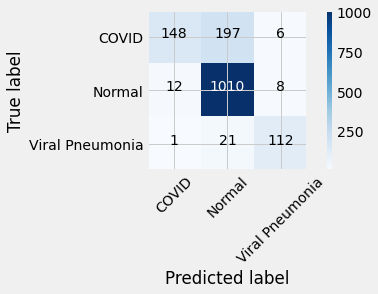

Epoch 6/100
379/379 [==============================] - 157s 414ms/step - loss: 0.4495 - accuracy: 0.8051 - f1_m: 0.8024 - precision_m: 0.8122 - recall_m: 0.7931 - val_loss: 0.3591 - val_accuracy: 0.8548 - val_f1_m: 0.8535 - val_precision_m: 0.8609 - val_recall_m: 0.8464

Epoch 00006: val_loss improved from 0.36747 to 0.35905, saving model to best_model1.h5


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


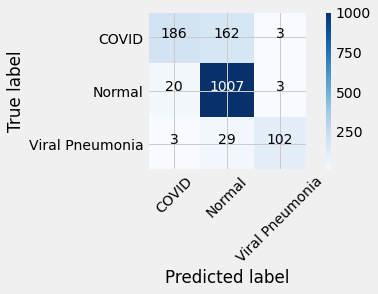

Epoch 7/100
379/379 [==============================] - 157s 413ms/step - loss: 0.4252 - accuracy: 0.8184 - f1_m: 0.8166 - precision_m: 0.8249 - recall_m: 0.8086 - val_loss: 0.3216 - val_accuracy: 0.8759 - val_f1_m: 0.8740 - val_precision_m: 0.8790 - val_recall_m: 0.8692

Epoch 00007: val_loss improved from 0.35905 to 0.32160, saving model to best_model1.h5


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


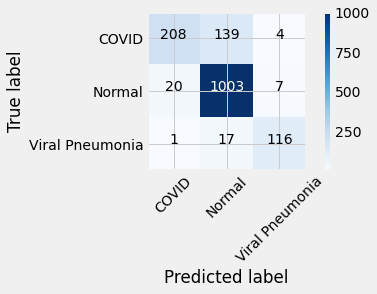

Epoch 8/100
379/379 [==============================] - 158s 416ms/step - loss: 0.4141 - accuracy: 0.8235 - f1_m: 0.8232 - precision_m: 0.8303 - recall_m: 0.8165 - val_loss: 0.3045 - val_accuracy: 0.8792 - val_f1_m: 0.8784 - val_precision_m: 0.8825 - val_recall_m: 0.8744

Epoch 00008: val_loss improved from 0.32160 to 0.30450, saving model to best_model1.h5


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


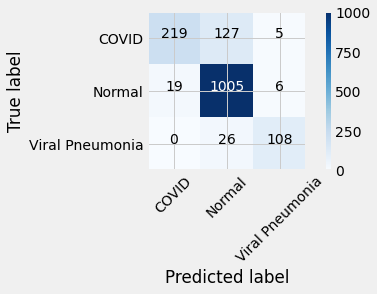

Epoch 9/100
379/379 [==============================] - 158s 417ms/step - loss: 0.3952 - accuracy: 0.8352 - f1_m: 0.8337 - precision_m: 0.8406 - recall_m: 0.8272 - val_loss: 0.2806 - val_accuracy: 0.8924 - val_f1_m: 0.8919 - val_precision_m: 0.8946 - val_recall_m: 0.8894

Epoch 00009: val_loss improved from 0.30450 to 0.28063, saving model to best_model1.h5


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


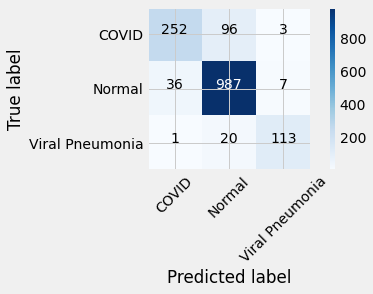

Epoch 10/100
379/379 [==============================] - 157s 414ms/step - loss: 0.3842 - accuracy: 0.8376 - f1_m: 0.8364 - precision_m: 0.8420 - recall_m: 0.8311 - val_loss: 0.2840 - val_accuracy: 0.8924 - val_f1_m: 0.8926 - val_precision_m: 0.8972 - val_recall_m: 0.8881

Epoch 00010: val_loss did not improve from 0.28063


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


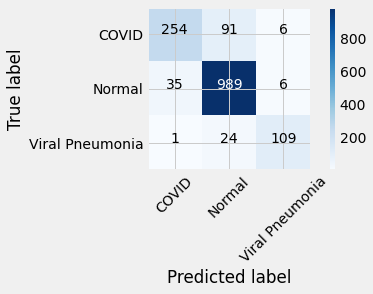

Epoch 11/100
379/379 [==============================] - 158s 417ms/step - loss: 0.3679 - accuracy: 0.8454 - f1_m: 0.8450 - precision_m: 0.8501 - recall_m: 0.8402 - val_loss: 0.3016 - val_accuracy: 0.8759 - val_f1_m: 0.8768 - val_precision_m: 0.8812 - val_recall_m: 0.8725

Epoch 00011: val_loss did not improve from 0.28063


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


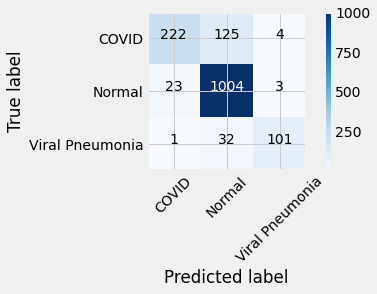

Epoch 12/100
379/379 [==============================] - 157s 415ms/step - loss: 0.3570 - accuracy: 0.8503 - f1_m: 0.8500 - precision_m: 0.8546 - recall_m: 0.8456 - val_loss: 0.2627 - val_accuracy: 0.9030 - val_f1_m: 0.9028 - val_precision_m: 0.9059 - val_recall_m: 0.8999

Epoch 00012: val_loss improved from 0.28063 to 0.26268, saving model to best_model1.h5


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


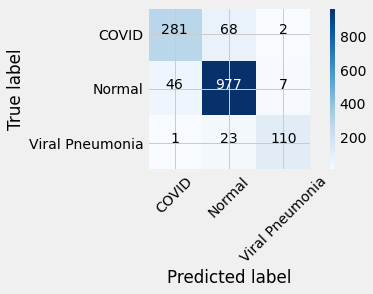

Epoch 13/100
379/379 [==============================] - 157s 415ms/step - loss: 0.3526 - accuracy: 0.8551 - f1_m: 0.8541 - precision_m: 0.8595 - recall_m: 0.8489 - val_loss: 0.2544 - val_accuracy: 0.8964 - val_f1_m: 0.8975 - val_precision_m: 0.8999 - val_recall_m: 0.8952

Epoch 00013: val_loss improved from 0.26268 to 0.25439, saving model to best_model1.h5


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


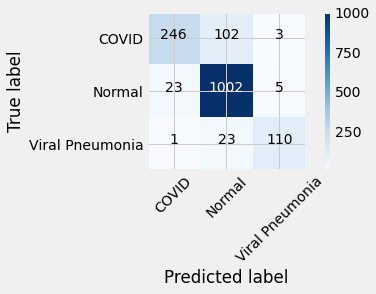

Epoch 14/100
379/379 [==============================] - 157s 415ms/step - loss: 0.3423 - accuracy: 0.8553 - f1_m: 0.8549 - precision_m: 0.8604 - recall_m: 0.8496 - val_loss: 0.2442 - val_accuracy: 0.9069 - val_f1_m: 0.9055 - val_precision_m: 0.9072 - val_recall_m: 0.9038

Epoch 00014: val_loss improved from 0.25439 to 0.24425, saving model to best_model1.h5


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


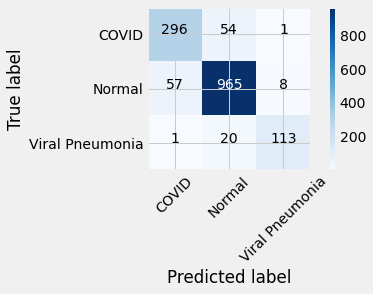

Epoch 15/100
379/379 [==============================] - 158s 417ms/step - loss: 0.3309 - accuracy: 0.8592 - f1_m: 0.8584 - precision_m: 0.8629 - recall_m: 0.8541 - val_loss: 0.2414 - val_accuracy: 0.9036 - val_f1_m: 0.9023 - val_precision_m: 0.9036 - val_recall_m: 0.9012

Epoch 00015: val_loss improved from 0.24425 to 0.24138, saving model to best_model1.h5


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


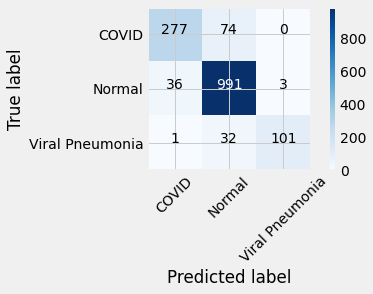

Epoch 16/100
379/379 [==============================] - 159s 419ms/step - loss: 0.3216 - accuracy: 0.8683 - f1_m: 0.8670 - precision_m: 0.8708 - recall_m: 0.8633 - val_loss: 0.2194 - val_accuracy: 0.9129 - val_f1_m: 0.9103 - val_precision_m: 0.9124 - val_recall_m: 0.9083

Epoch 00016: val_loss improved from 0.24138 to 0.21942, saving model to best_model1.h5


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


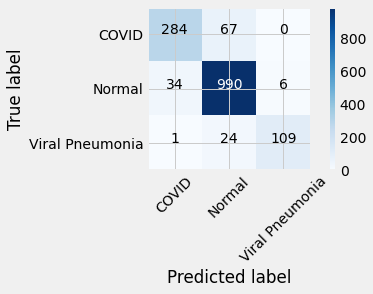

Epoch 17/100
379/379 [==============================] - 159s 418ms/step - loss: 0.3127 - accuracy: 0.8684 - f1_m: 0.8687 - precision_m: 0.8721 - recall_m: 0.8655 - val_loss: 0.2157 - val_accuracy: 0.9155 - val_f1_m: 0.9146 - val_precision_m: 0.9164 - val_recall_m: 0.9128

Epoch 00017: val_loss improved from 0.21942 to 0.21574, saving model to best_model1.h5


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


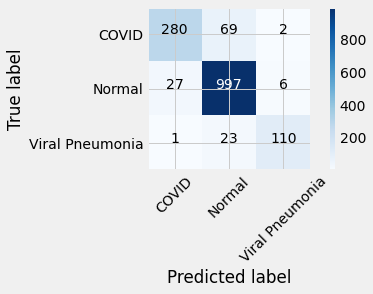

Epoch 18/100
379/379 [==============================] - 157s 413ms/step - loss: 0.2986 - accuracy: 0.8787 - f1_m: 0.8781 - precision_m: 0.8813 - recall_m: 0.8751 - val_loss: 0.2358 - val_accuracy: 0.9076 - val_f1_m: 0.9076 - val_precision_m: 0.9088 - val_recall_m: 0.9064

Epoch 00018: val_loss did not improve from 0.21574


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


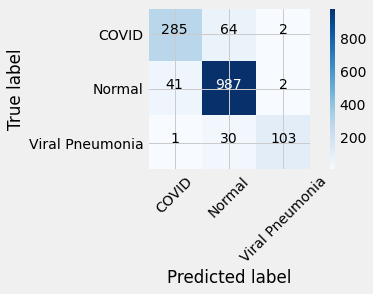

Epoch 19/100
379/379 [==============================] - 156s 412ms/step - loss: 0.3013 - accuracy: 0.8759 - f1_m: 0.8759 - precision_m: 0.8793 - recall_m: 0.8725 - val_loss: 0.2164 - val_accuracy: 0.9155 - val_f1_m: 0.9143 - val_precision_m: 0.9158 - val_recall_m: 0.9128

Epoch 00019: val_loss did not improve from 0.21574


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


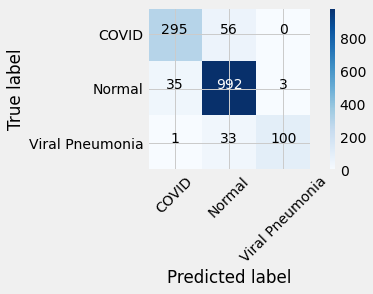

Epoch 20/100
379/379 [==============================] - 157s 413ms/step - loss: 0.2946 - accuracy: 0.8773 - f1_m: 0.8769 - precision_m: 0.8806 - recall_m: 0.8733 - val_loss: 0.2329 - val_accuracy: 0.9083 - val_f1_m: 0.9078 - val_precision_m: 0.9087 - val_recall_m: 0.9070

Epoch 00020: val_loss did not improve from 0.21574


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


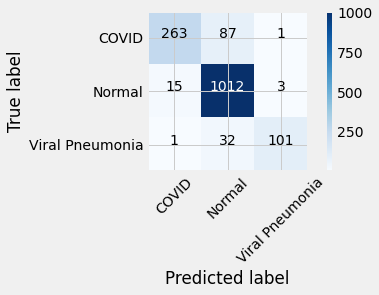

Epoch 21/100
379/379 [==============================] - 157s 413ms/step - loss: 0.2912 - accuracy: 0.8823 - f1_m: 0.8822 - precision_m: 0.8855 - recall_m: 0.8789 - val_loss: 0.1978 - val_accuracy: 0.9248 - val_f1_m: 0.9235 - val_precision_m: 0.9251 - val_recall_m: 0.9220

Epoch 00021: val_loss improved from 0.21574 to 0.19775, saving model to best_model1.h5


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


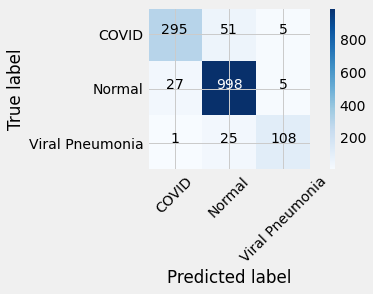

Epoch 22/100
379/379 [==============================] - 158s 417ms/step - loss: 0.2792 - accuracy: 0.8881 - f1_m: 0.8876 - precision_m: 0.8904 - recall_m: 0.8848 - val_loss: 0.2023 - val_accuracy: 0.9221 - val_f1_m: 0.9215 - val_precision_m: 0.9225 - val_recall_m: 0.9206

Epoch 00022: val_loss did not improve from 0.19775


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


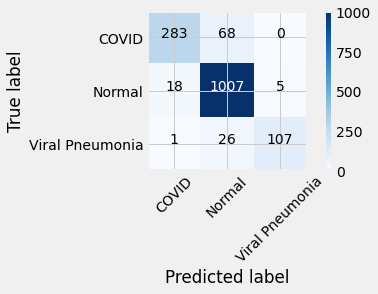

Epoch 23/100
379/379 [==============================] - 159s 421ms/step - loss: 0.2700 - accuracy: 0.8911 - f1_m: 0.8907 - precision_m: 0.8931 - recall_m: 0.8883 - val_loss: 0.2317 - val_accuracy: 0.9116 - val_f1_m: 0.9113 - val_precision_m: 0.9131 - val_recall_m: 0.9096

Epoch 00023: val_loss did not improve from 0.19775


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


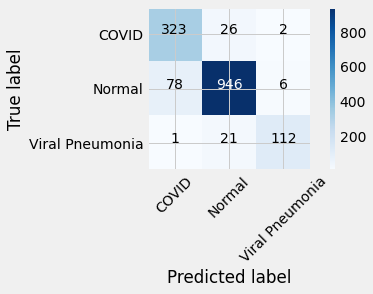

Epoch 24/100
379/379 [==============================] - 157s 415ms/step - loss: 0.2687 - accuracy: 0.8927 - f1_m: 0.8926 - precision_m: 0.8949 - recall_m: 0.8903 - val_loss: 0.1923 - val_accuracy: 0.9254 - val_f1_m: 0.9242 - val_precision_m: 0.9251 - val_recall_m: 0.9233

Epoch 00024: val_loss improved from 0.19775 to 0.19226, saving model to best_model1.h5


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


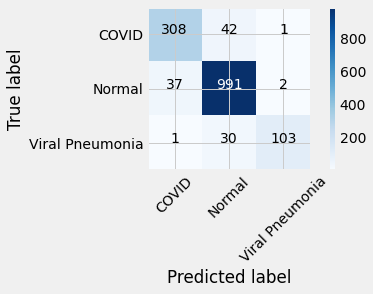

Epoch 25/100
379/379 [==============================] - 156s 412ms/step - loss: 0.2633 - accuracy: 0.8960 - f1_m: 0.8954 - precision_m: 0.8978 - recall_m: 0.8931 - val_loss: 0.1896 - val_accuracy: 0.9327 - val_f1_m: 0.9319 - val_precision_m: 0.9329 - val_recall_m: 0.9310

Epoch 00025: val_loss improved from 0.19226 to 0.18964, saving model to best_model1.h5


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


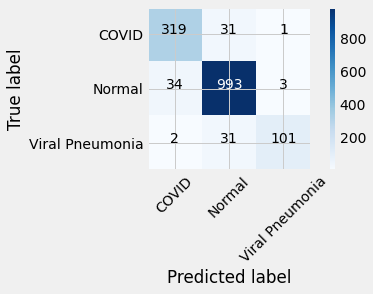

Epoch 26/100
379/379 [==============================] - 156s 412ms/step - loss: 0.2640 - accuracy: 0.8938 - f1_m: 0.8931 - precision_m: 0.8959 - recall_m: 0.8904 - val_loss: 0.2123 - val_accuracy: 0.9195 - val_f1_m: 0.9181 - val_precision_m: 0.9187 - val_recall_m: 0.9174

Epoch 00026: val_loss did not improve from 0.18964


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


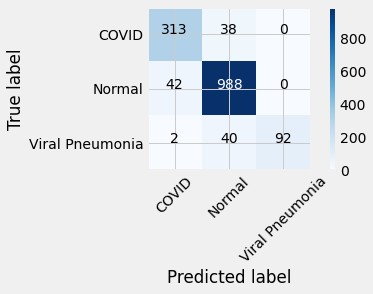

Epoch 27/100
379/379 [==============================] - 157s 413ms/step - loss: 0.2493 - accuracy: 0.9015 - f1_m: 0.9015 - precision_m: 0.9034 - recall_m: 0.8996 - val_loss: 0.2007 - val_accuracy: 0.9261 - val_f1_m: 0.9245 - val_precision_m: 0.9251 - val_recall_m: 0.9239

Epoch 00027: val_loss did not improve from 0.18964


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


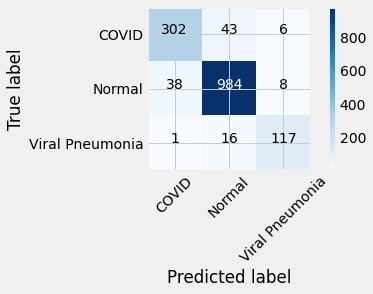

Epoch 28/100
379/379 [==============================] - 156s 412ms/step - loss: 0.2515 - accuracy: 0.8999 - f1_m: 0.8996 - precision_m: 0.9019 - recall_m: 0.8974 - val_loss: 0.1750 - val_accuracy: 0.9360 - val_f1_m: 0.9352 - val_precision_m: 0.9367 - val_recall_m: 0.9337

Epoch 00028: val_loss improved from 0.18964 to 0.17501, saving model to best_model1.h5


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


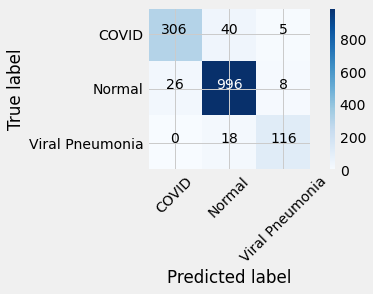

Epoch 29/100
379/379 [==============================] - 156s 413ms/step - loss: 0.2430 - accuracy: 0.9033 - f1_m: 0.9030 - precision_m: 0.9053 - recall_m: 0.9009 - val_loss: 0.1920 - val_accuracy: 0.9294 - val_f1_m: 0.9286 - val_precision_m: 0.9307 - val_recall_m: 0.9265

Epoch 00029: val_loss did not improve from 0.17501


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


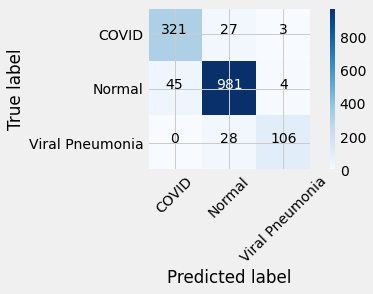

Epoch 30/100
379/379 [==============================] - 157s 414ms/step - loss: 0.2398 - accuracy: 0.9040 - f1_m: 0.9039 - precision_m: 0.9061 - recall_m: 0.9017 - val_loss: 0.1652 - val_accuracy: 0.9360 - val_f1_m: 0.9371 - val_precision_m: 0.9386 - val_recall_m: 0.9356

Epoch 00030: val_loss improved from 0.17501 to 0.16522, saving model to best_model1.h5


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


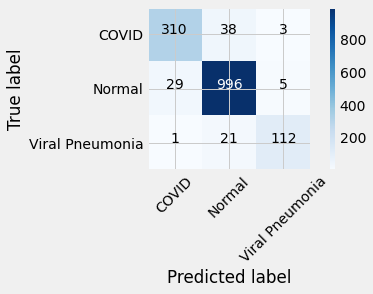

Epoch 31/100
379/379 [==============================] - 157s 414ms/step - loss: 0.2370 - accuracy: 0.9077 - f1_m: 0.9075 - precision_m: 0.9096 - recall_m: 0.9054 - val_loss: 0.1793 - val_accuracy: 0.9353 - val_f1_m: 0.9352 - val_precision_m: 0.9355 - val_recall_m: 0.9350

Epoch 00031: val_loss did not improve from 0.16522


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


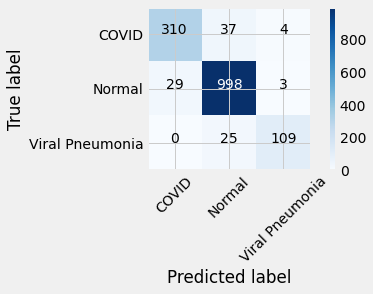

Epoch 32/100
379/379 [==============================] - 156s 413ms/step - loss: 0.2270 - accuracy: 0.9108 - f1_m: 0.9097 - precision_m: 0.9118 - recall_m: 0.9076 - val_loss: 0.1681 - val_accuracy: 0.9353 - val_f1_m: 0.9343 - val_precision_m: 0.9349 - val_recall_m: 0.9337

Epoch 00032: val_loss did not improve from 0.16522


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


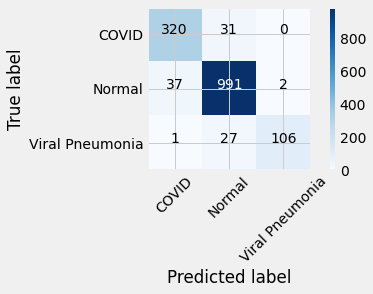

Epoch 33/100
379/379 [==============================] - 157s 413ms/step - loss: 0.2259 - accuracy: 0.9120 - f1_m: 0.9119 - precision_m: 0.9133 - recall_m: 0.9104 - val_loss: 0.1561 - val_accuracy: 0.9419 - val_f1_m: 0.9414 - val_precision_m: 0.9421 - val_recall_m: 0.9408

Epoch 00033: val_loss improved from 0.16522 to 0.15611, saving model to best_model1.h5


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


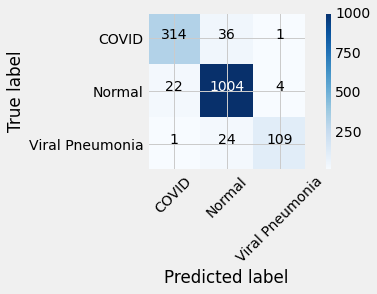

Epoch 34/100
379/379 [==============================] - 156s 411ms/step - loss: 0.2291 - accuracy: 0.9109 - f1_m: 0.9105 - precision_m: 0.9127 - recall_m: 0.9085 - val_loss: 0.1917 - val_accuracy: 0.9248 - val_f1_m: 0.9242 - val_precision_m: 0.9245 - val_recall_m: 0.9239

Epoch 00034: val_loss did not improve from 0.15611


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


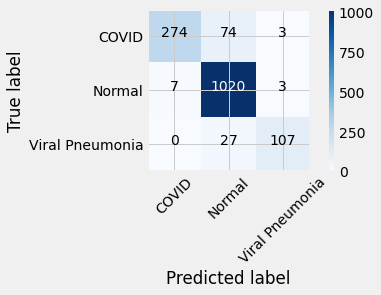

Epoch 35/100
379/379 [==============================] - 158s 416ms/step - loss: 0.2197 - accuracy: 0.9159 - f1_m: 0.9158 - precision_m: 0.9172 - recall_m: 0.9144 - val_loss: 0.1686 - val_accuracy: 0.9393 - val_f1_m: 0.9378 - val_precision_m: 0.9388 - val_recall_m: 0.9370

Epoch 00035: val_loss did not improve from 0.15611


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


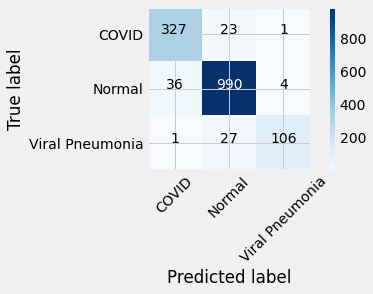

Epoch 36/100
379/379 [==============================] - 157s 414ms/step - loss: 0.2206 - accuracy: 0.9153 - f1_m: 0.9152 - precision_m: 0.9172 - recall_m: 0.9132 - val_loss: 0.1811 - val_accuracy: 0.9373 - val_f1_m: 0.9372 - val_precision_m: 0.9381 - val_recall_m: 0.9363

Epoch 00036: val_loss did not improve from 0.15611


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


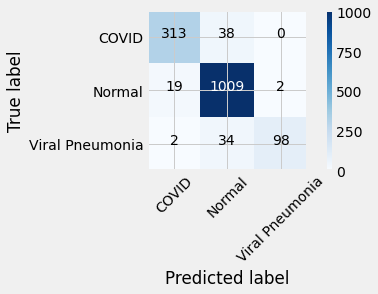

Epoch 37/100
379/379 [==============================] - 156s 411ms/step - loss: 0.2159 - accuracy: 0.9151 - f1_m: 0.9155 - precision_m: 0.9173 - recall_m: 0.9139 - val_loss: 0.1723 - val_accuracy: 0.9439 - val_f1_m: 0.9427 - val_precision_m: 0.9434 - val_recall_m: 0.9421

Epoch 00037: val_loss did not improve from 0.15611


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


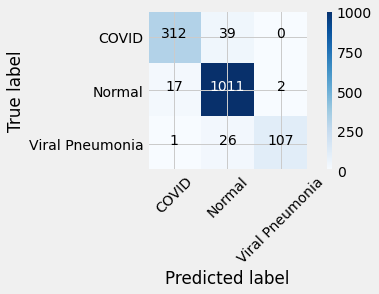

Epoch 38/100
379/379 [==============================] - 157s 413ms/step - loss: 0.2035 - accuracy: 0.9225 - f1_m: 0.9227 - precision_m: 0.9241 - recall_m: 0.9214 - val_loss: 0.1733 - val_accuracy: 0.9393 - val_f1_m: 0.9385 - val_precision_m: 0.9394 - val_recall_m: 0.9376

Epoch 00038: val_loss did not improve from 0.15611


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


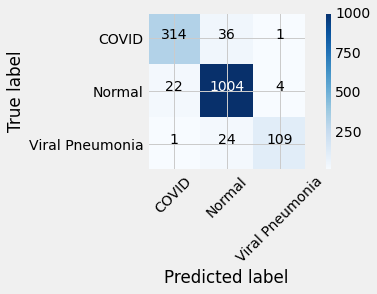

Trained


In [34]:
trained = train(model, train_generator, val_generator, toy)

# MODEL EVALUATION

## Generate Predictions

In [35]:
y_pred_raw = model.predict(test_generator)
y_pred = np.argmax(y_pred_raw, axis=1)
y_true = test.category.values
y_true=y_true[:len(y_pred)]

## Metrics Plot Functions

In [36]:
def plot_history(training):
        """
        Plot training history
        """
        ## Trained model analysis and evaluation
        f, ax = plt.subplots(1,2, figsize=(15,8))
        ax[0].plot(training.history['loss'], label="Loss")
        ax[0].plot(training.history['val_loss'], label="Validation loss")
        ax[0].set_title('Loss')
        ax[0].set_xlabel('Epoch')
        ax[0].set_ylabel('Loss')
        ax[0].legend()

        # Accuracy
        ax[1].plot(training.history['accuracy'], label="Accuracy")
        ax[1].plot(training.history['val_accuracy'], label="Validation accuracy")
        ax[1].set_title('Accuracy')
        ax[1].set_xlabel('Epoch')
        ax[1].set_ylabel('Accuracy')
        ax[1].legend()
        plt.tight_layout()
        plt.show()

def train_report(training):
    print("------- Training Report -----------")
    print("Accuracy: %0.2f" % (np.mean(training.history['accuracy'])*100))
    print("F1 Score: %0.2f" % (np.mean(training.history['f1_m'])*100))
    print("Precision: %0.2f" % (np.mean(training.history['precision_m'])*100))
    print("Recall: %0.2f" % (np.mean(training.history['recall_m'])*100))

    print("------- Validation Report -----------")
    print("Accuracy: %0.2f" % (np.mean(training.history['val_accuracy'])*100))
    print("F1 Score: %0.2f" % (np.mean(training.history['val_f1_m'])*100))
    print("Precision: %0.2f" % (np.mean(training.history['val_precision_m'])*100))
    print("Recall: %0.2f" % (np.mean(training.history['val_recall_m'])*100))

def print_report():
    """
    Predict and evaluate using ground truth from labels
    Test generator did not shuffle 
    and we can use true labels for comparison
    """
    #Print classification report
    print(metrics.classification_report(y_true, y_pred.astype(str), target_names = labels))
    
def print_conf_mtx():
    
    cm = confusion_matrix(y_true.astype(int), y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2])

    disp.plot(cmap=plt.cm.Blues)
    plt.show()

def multiclass_roc_auc_score(y_test, y_pred, average="weighted"):
    fig, c_ax = plt.subplots(1,1, figsize = (12, 8))
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(labels):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
        
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    c_ax.set_title('ROC Curve')
    print('ROC AUC Score:', roc_auc_score(y_test, y_pred, average=average))
    plt.show()

## Results

------- Training Report -----------
Accuracy: 86.35
F1 Score: 86.25
Precision: 86.78
Recall: 85.76
------- Validation Report -----------
Accuracy: 90.25
F1 Score: 90.10
Precision: 90.64
Recall: 89.63


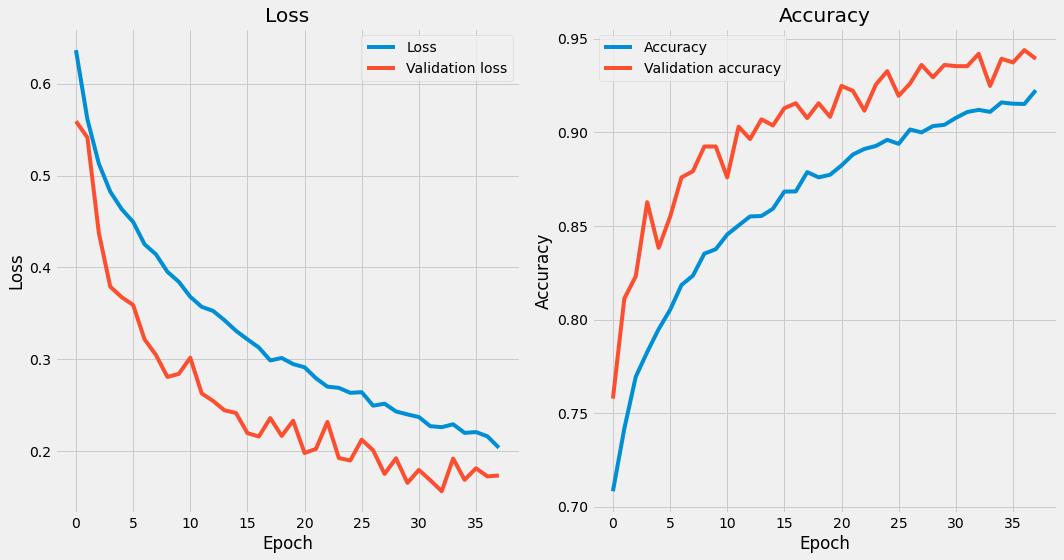

ROC AUC Score: 0.9271247696909426


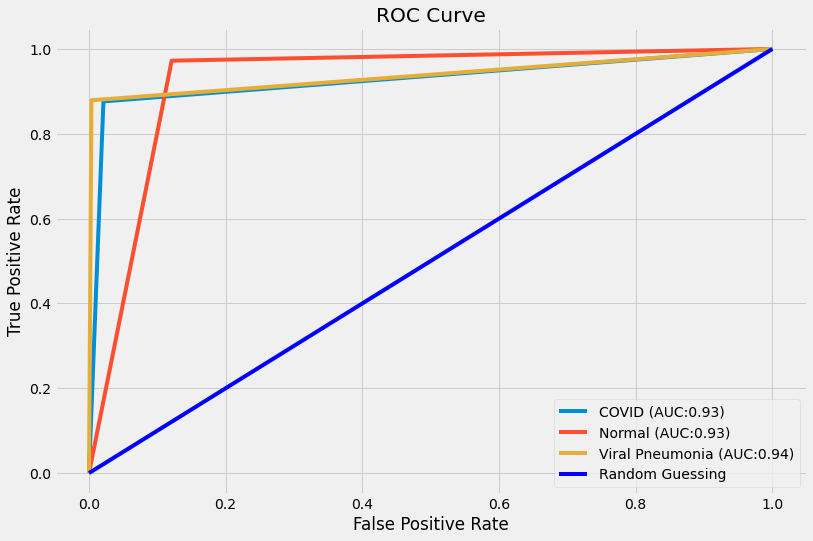

                 precision    recall  f1-score   support

          COVID       0.93      0.88      0.90       380
         Normal       0.94      0.97      0.96      1012
Viral Pneumonia       0.96      0.88      0.92       124

       accuracy                           0.94      1516
      macro avg       0.94      0.91      0.93      1516
   weighted avg       0.94      0.94      0.94      1516



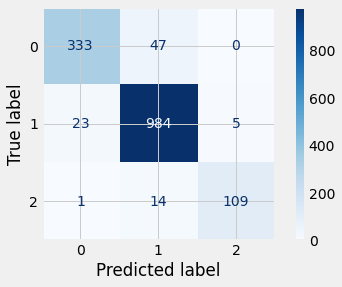

In [37]:
train_report(trained)
plot_history(trained)
multiclass_roc_auc_score(y_true.astype(int), y_pred)
print_report()
print_conf_mtx()